# importing functions

In [172]:
import random
from itertools import count
from matplotlib.animation import FuncAnimation
import time
import matplotlib.pyplot as plt
import follow_road

%run localisation.ipynb
%run follow_road.py

In [118]:
# Import tdmclient Notebook environment:
import tdmclient.notebook

In [119]:
await tdmclient.notebook.start()

In [ ]:
await tdmclient.notebook.stop()

In [120]:
S=[0,0,0]

In [121]:
kinematics2(S,50,50,1000)

[250.0, 0.0, 0.0]

In [122]:
traj=square=([[  0 , 10],
 [-10 ,  0],
 [  0, -10],
 [ 10 ,  0]])

In [123]:
square

[[0, 10], [-10, 0], [0, -10], [10, 0]]

In [124]:
square.append(square[0])

# Graphical functions

In [127]:
def draw_trajectory(traj) :
    #fig=plt.figure()
    #ax1=fig.add_subplot(111)
    #ax2=fig.add_subplot(221)
    xs, ys = zip(*traj)
    plt.plot(xs,ys)
    #ax1.set_aspect('equal')
    return

Unchecked Starred(value=Name(id='traj', ctx=Load()), ctx=Load())


In [128]:
def draw_thymio(pose) :
    move=pose[0:2]
    angle=pose[2]-math.pi/2
    thymio_shape=[[-0.5,-0.5],[0.5,-0.5],[0.5,0.25],[0,0.75],[-0.5,0.25]]
    
    thymio_shape.append(thymio_shape[0]) #repeat the first point to create a 'closed loop'
    rot=np.array([[np.cos(angle) , -np.sin(angle)],[np.sin(angle),np.cos(angle)]])
    thymio_shape=(np.transpose((np.matmul(rot,np.transpose(100*np.array(thymio_shape))))))
    thymio_shape+=[move,move,move,move,move,move]
    xs, ys = zip(*thymio_shape) #create lists of x and y values
    fig=plt.figure(figsize=(8, 8), dpi=80)

    ax = fig.add_subplot(111)
    ax.set_aspect('equal')

    plt.xlim((-1000,1000))
    plt.ylim((-1000,1000))
    plt.plot(xs,ys)
    return thymio_shape

Unchecked Starred(value=Name(id='thymio_shape', ctx=Load()), ctx=Load())


In [129]:
def draw_now(pose,traj) :
    draw_thymio(pose)
    draw_trajectory(traj)
    plt.show()
    return


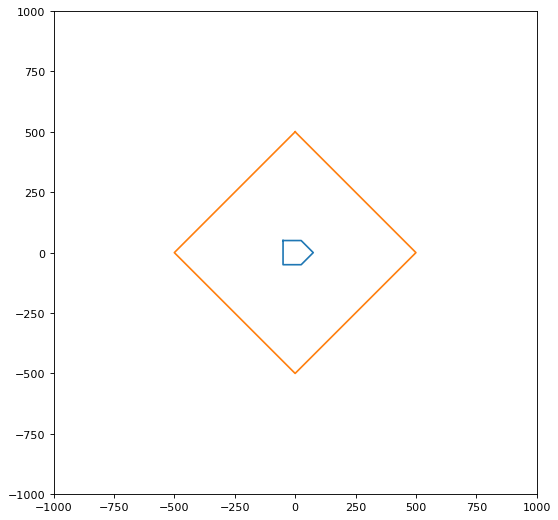

In [130]:
draw_now(S,trajnp)

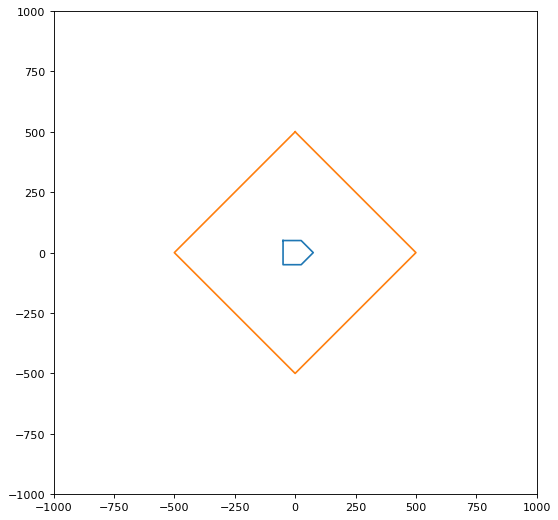

array([[-5.0000000e+01,  5.0000000e+01],
       [-5.0000000e+01, -5.0000000e+01],
       [ 2.5000000e+01, -5.0000000e+01],
       [ 7.5000000e+01,  4.5924255e-15],
       [ 2.5000000e+01,  5.0000000e+01],
       [-5.0000000e+01,  5.0000000e+01]])

In [131]:
thymio_shape=draw_thymio([0,0,0])
draw_trajectory(trajnp)
plt.show()
thymio_shape

# stop and turn approach

In [159]:
def inverse_kin(pose,obj) :
    global motor_left_target, motor_right_target
    angle_thres=math.pi/12
    angle=theta_des(pose,obj)
    error=angle-pose[2]
    if error>math.pi : 
        error-=2*math.pi
    if error< -(math.pi) :
        error+=2*math.pi
    speed=200
    coeff=100*5/math.pi # experimental value : half a turn with speed=100 takes 5 seconds
    t=abs(error)/speed*coeff
    
    vl=-np.sign(error)*speed
    vr=-vl
    motor_left_target = int(vl)
    motor_right_target = int(vr)
    
    time.sleep(2.5)
    
    motor_left_target = 0
    motor_right_target = 0
    return [vl,vr,t]
    

[-200.0, 200.0, 1.2500000000000002]


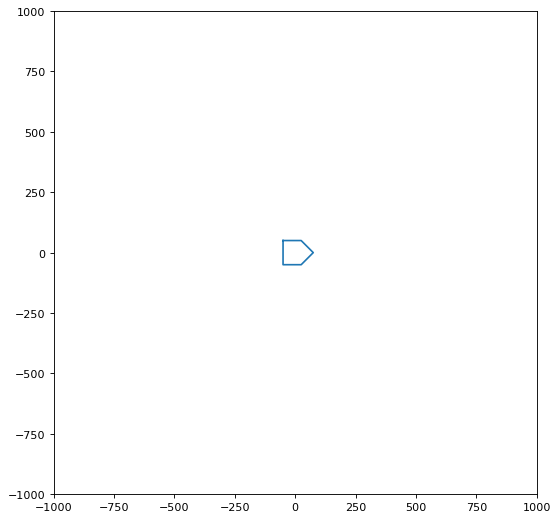

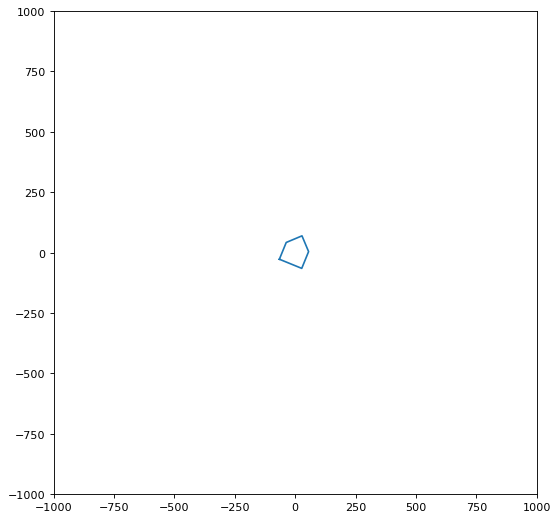

In [210]:
pose=[0,0,0]
draw_thymio(pose)
vl=vr=0
next_point=[0,500]

[vl,vr,dt]=inverse_kin(pose,next_point)
pose=kinematics2(pose,vl,vr,dt*1000)
draw_thymio(pose)
print([vl,vr,dt])

In [211]:
motor_left_target = int(vl)
motor_right_target = int(vr)
sleep(dt)
    
motor_left_target = 300
motor_right_target = 300
sleep(2)
motor_left_target = 0
motor_right_target = 0

In [ ]:
t=float(0.5)
if 1 :
    motor_left_target = -100
    motor_right_target = 100
sleep(t)
motor_left_target = 100
motor_right_target = -100
sleep(t)
motor_left_target = 0
motor_right_target = 0

In [209]:
motor_left_target = 0
motor_right_target = 0

# PID controller

In [135]:
traj[0]
trajnp=50*np.array(traj)
trajnp

array([[   0,  500],
       [-500,    0],
       [   0, -500],
       [ 500,    0],
       [   0,  500]])

In [218]:
def PID(e,ediff,eint) :

    Kp=12
    Ki=0.05
    Kd=0
    correction=Kp*e+Ki*eint+Kd*ediff
    return correction

def theta_des(pos,obj) :
    '''
    orientation desired to face towards the goal
    
    '''
    return math.atan2(obj[1]-pos[1],obj[0]-pos[0])

def speed_des(pos,obj) :
    '''
    straight line speed desired, constant component + variable 
    component depending on distance to next point
    '''
    vbase=100
    coeff=0.5 # weight of variable component
    return vbase+coeff*math.sqrt((obj[1]-pos[1])**2+(obj[0]-pos[0])**2)

def wheel_inputs(omega,v) :
    '''
    calculates the motor speeds for the robot
    
    Arguments:
        - omega: correction, output of the PID
        - v: desired straight line speed
    Outputs:
        - [vl,vr]: left and right motor speeds 
    
    '''
    R=20 #wheel radius in [mm]
    L=95 #distance between wheels in [mm]
    vl=5*(2*v-omega*L)/(2*R) #left motor speed
    vr=5*(2*v+omega*L)/(2*R) #right motor speed
    
    #### setting lower and upper bounds ####
    if vr<0 :
        vr=max(-300,vr)
    else :
        vr=min(300,vr)
        
    if vl<0 :
        vl=max(-300,vl)
    else :
        vl=min(300,vl)

    
    return [int(vl),int(vr)]

def compute_error(pose,obj) : 
    angle=theta_des(pose,obj)
    error=angle-pose[2]
    if error>math.pi : 
        error-=2*math.pi
    if error< -(math.pi) :
        error+=2*math.pi
    return error

In [225]:
def follow_path(pose,traj) :
    # following the path
    # initialisation 
    dt=100 # control period
    pose=[200,200,-math.pi/2] #initial pose
    myPose=Pose(pose)
    vl=vr=0
    nx_pt_id=0 # index of the next point to attain in the trajectory, set as 0 to start
    next_point=trajnp[nx_pt_id]
    prev_error=0 
    e_int=0
    distance_to_goal=dist(pose)
    iter=0

    while distance_to_goal > 5 and nx_pt_id<len(traj)-1 : # main control loop
        
        ########     get position    #######
        
        #pose=kinematics2(pose,vl,vr,dt)
        mypose.update([vl,vr],prox_ground_reflected,dt,myMap)
        pose=list(myPose.get_coords().values()) #pose in list form for low level functions
        #angle=theta_des(pose,next_point)
        v=speed_des(pose,next_point) 
        
        
        ########    call pid   ##########
        error=compute_error(pose,next_point)
        e_diff=(error-prev_error)/dt
        e_int+=error
        omega=PID(error,e_diff,e_int)

        #######  set wheel speeds    #######
        [vl,vr]=wheel_inputs(omega,v)
        motor_left_target = vl
        motor_right_target = vr
        sleep(dt/1000) # control period in [s]
        

        ##### update next point ######
        if dist(pose,next_point) < 5 : 
            nx_pt_id+=1
            next_point=trajnp[nx_pt_id]

        #####  update distance to final point  #####
        distance_to_goal=dist(pose,trajnp[-2]) 


        #####    graph  ####
        if iter % 20 ==0 : 
            print (myPose.get_coords())
            print(error,e_diff,e_int)
            print([vl,vr])
            print(distance_to_goal)

            draw_now(pose,trajnp)

    
        iter+=1

    return

In [226]:
motor_left_target=0
motor_right_target=-0

Error in callback <function _post_run_cell at 0x7f9ba8607790> (for post_run_cell):


BrokenPipeError: [Errno 32] Broken pipe

In [204]:
5%3

2

In [196]:
prox_ground_delta

[739, 644]

In [217]:
x=myPose.get_coords()
x['theta']

-1.5707963267948966

In [220]:
trajnp

array([[   0,  500],
       [-500,    0],
       [   0, -500],
       [ 500,    0],
       [   0,  500]])

In [222]:
len(trajnp)

5